In [235]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import xgbfir

from tqdm import tqdm_notebook, tnrange

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [127]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [137]:
burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

burst_params = ['interburst_interval', 'mean_isi_in_burst', 'median_isi_in_burst', 'mean_spikes_in_burst'] + burst_oscore_cols

spiketrain_params = ['burst_mean', 'cv', 'firing_rate', 'frequency_variance', 'isi_mean', 'isi_median', 'isi_std',
                    'kurtoisis', 'lv', 'nu', 'oscore_12.0_20.0', 'oscore_20.0_30.0', 'oscore_3.0_8.0', 'oscore_30.0_60.0',
                     'oscore_60.0_90.0', 'oscore_8.0_12.0', 'skewness', 'burst_percent', 'burst_spike_percent']

In [138]:
data_awake = pd.read_excel('data/awake.xls')
data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length',
                             'burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)
data_awake = data_awake[spiketrain_params + burst_params + ['patient']]

for c in burst_oscore_cols:
    data_awake = data_awake[data_awake[c] > 0.]

In [139]:
data_sleep = pd.read_excel('data/sleep.xls')
data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length',
                             'burst_index', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)
data_sleep = data_sleep[spiketrain_params + burst_params + ['patient']]

for c in burst_oscore_cols:
    data_sleep = data_sleep[data_sleep[c] > 0.]

In [171]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)
patients = data['patient']
data = data.drop(['patient'], axis=1)

old_cols = list(data.columns.values)
data.columns = list(range(1, len(old_cols) + 1))

spiketrain_idx = [old_cols.index(p) + 1 for p in spiketrain_params]
burst_idx = [old_cols.index(p) + 1 for p in burst_params]

In [182]:
data.to_csv('all_params.csv', index=False)
data[spiketrain_idx + [30]].to_csv('spiketrain_params.csv', index=False)
data[burst_idx + [30]].to_csv('burst_params.csv', index=False)

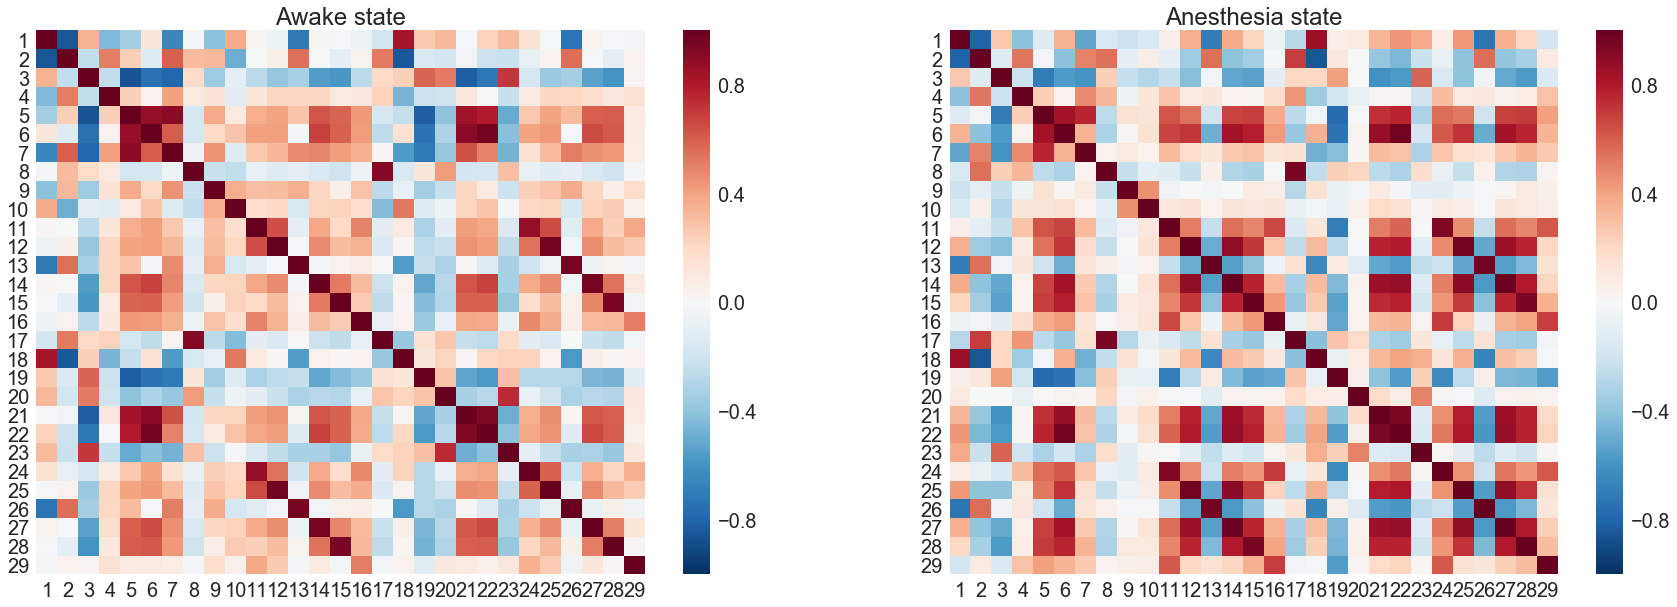

In [164]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30,10))
sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1).corr(), ax=ax1)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1).corr(), ax=ax2)
ax1.set_title('Awake state')
ax2.set_title('Anesthesia state')

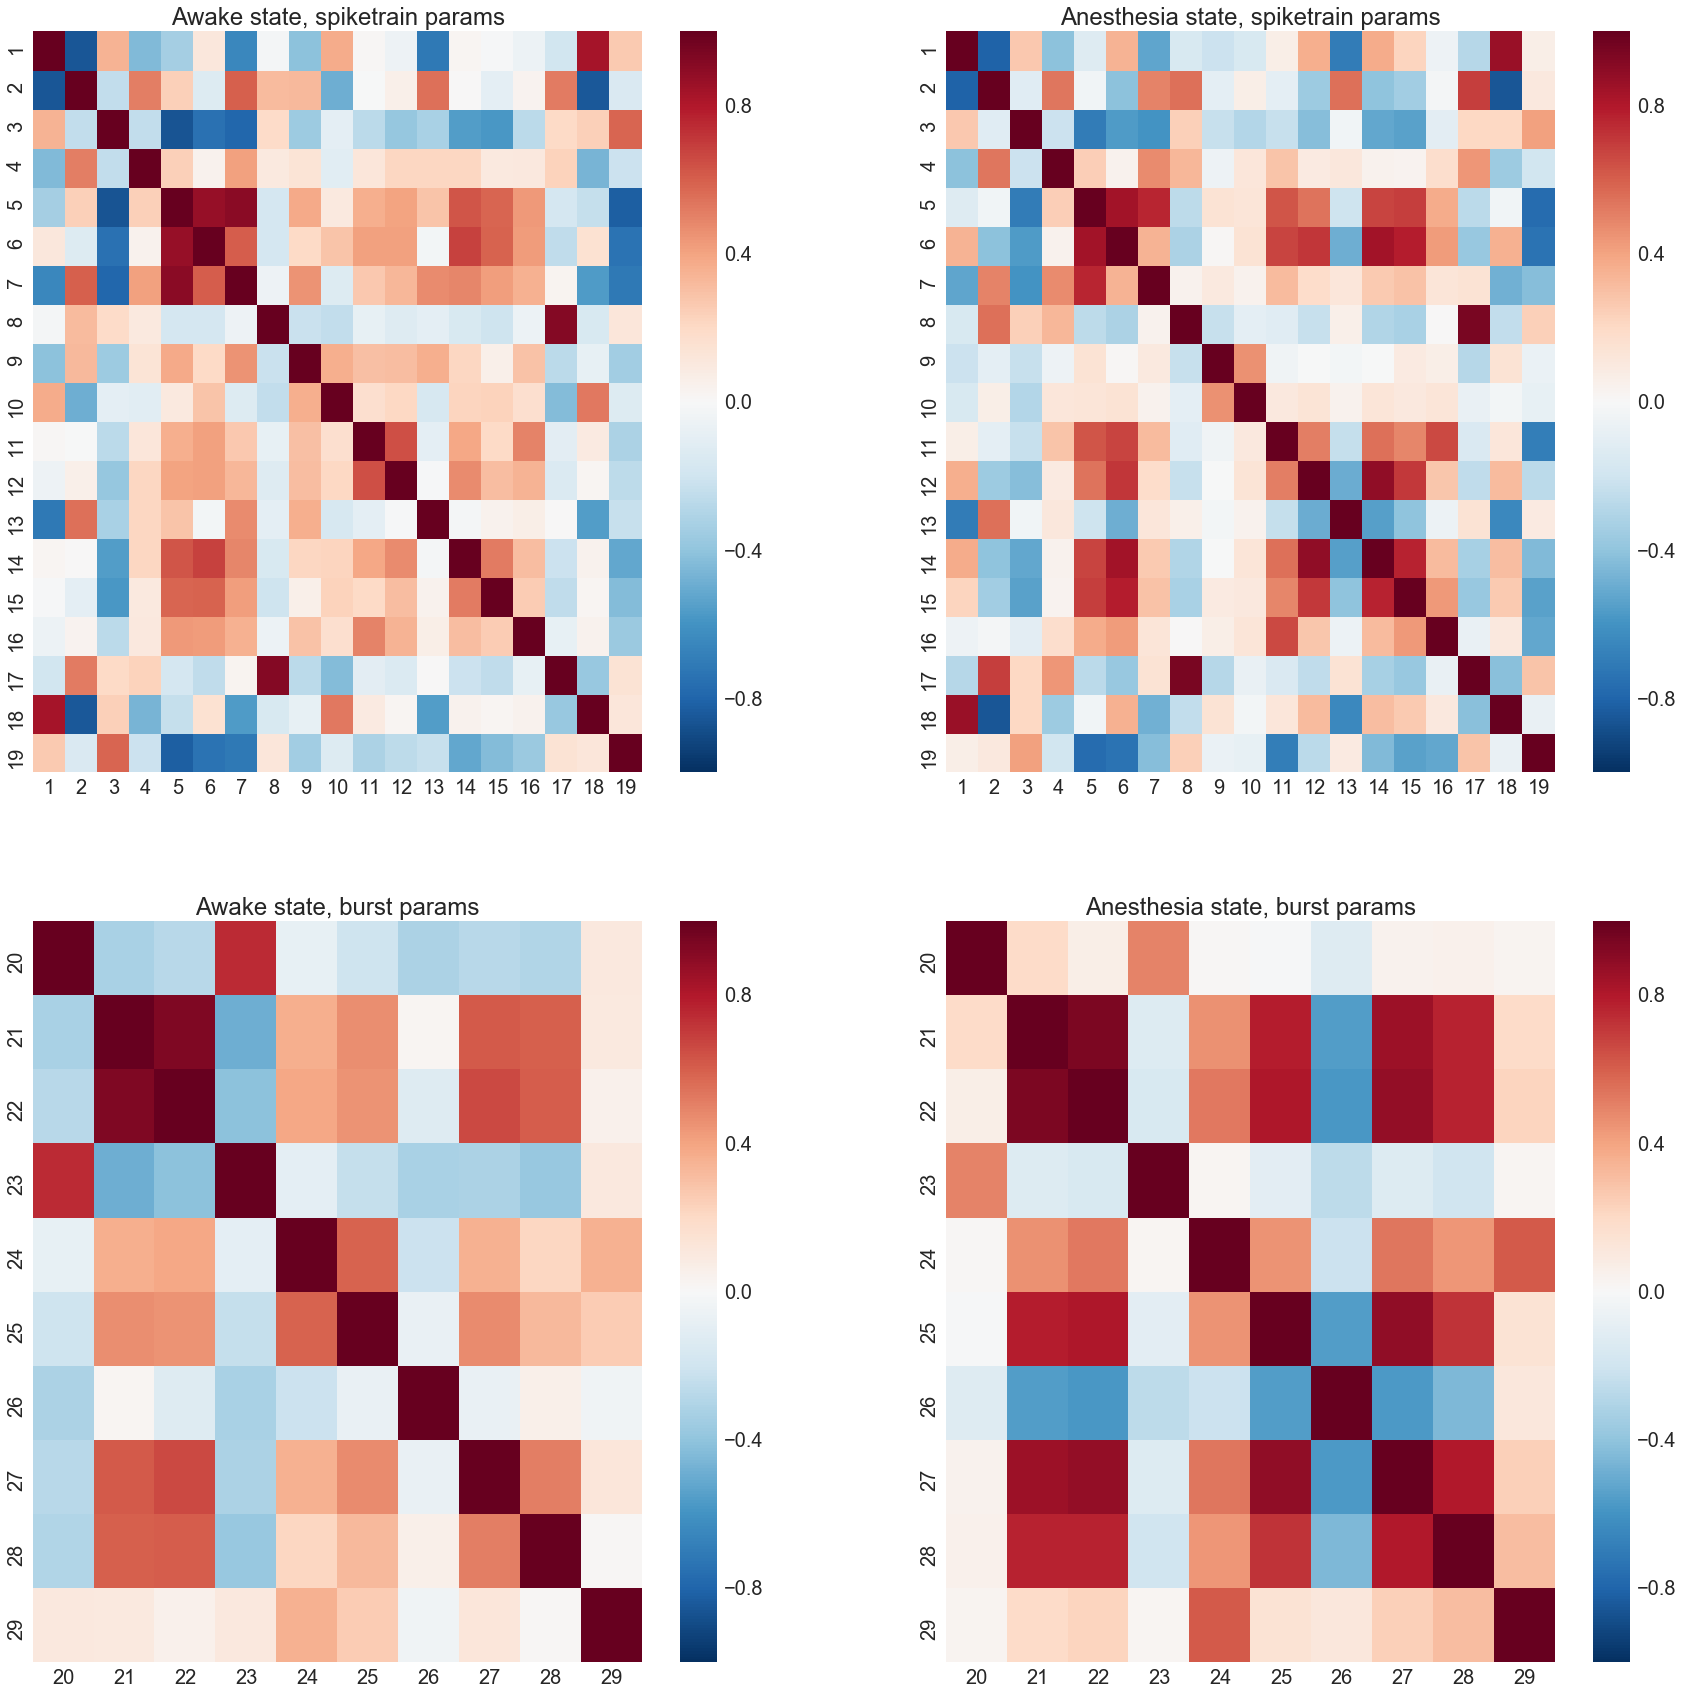

In [172]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(30,30))

sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1)[spiketrain_idx].corr(), ax=ax1)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1)[spiketrain_idx].corr(), ax=ax2)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1)[burst_idx].corr(), ax=ax3)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1)[burst_idx].corr(), ax=ax4)

ax1.set_title('Awake state, spiketrain params')
ax2.set_title('Anesthesia state, spiketrain params')
ax3.set_title('Awake state, burst params')
ax4.set_title('Anesthesia state, burst params')

In [183]:
awake_idx = old_cols.index('awake') + 1

X = data.drop(awake_idx, axis=1)
X_burst = data.drop(spiketrain_idx + [awake_idx], axis=1)
X_spiketrain = data.drop(burst_idx + [awake_idx], axis=1)

y = data[awake_idx]

In [206]:
def simple_cv(X, y, patients, model_type, params=None, plot=True):
    
    if model_type == 'xgb':
        model = xgb.XGBClassifier(**params)
    elif model_type == 'linear':
        model = LogisticRegression()

    acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        plt.figure(figsize=(15,10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('CV by folds, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
#     if save_params:
#         xgbfir.saveXgbFI(model.booster(), feature_names=X.columns.values, OutputXlsxFile = 'awake_interactions_depth_3.xlsx')
    
    return acc, auc_score

In [207]:
def patient_cv(X, y, patients, model_type, params=None, plot=True):
    all_idx = np.array(range(X.shape[0]))
    
    names = set(patients)
    
    X = X.as_matrix()
    y = np.array(y)
        
    y_pred = np.zeros(y.shape[0], dtype=int)
    probs = np.zeros(y.shape[0], dtype=float)
    acc = list()
    
    for p in names:
        test_idx = np.where(patients == p)
        train_idx = np.delete(all_idx, test_idx, 0)
        
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        if model_type == 'xgb':
            model = xgb.XGBClassifier(**params)
        elif model_type == 'linear':
            model = LogisticRegression()

        model.fit(X_train, y_train)
        
        curr_pred = model.predict(X_test)
        
        y_pred[test_idx] = curr_pred
        probs[test_idx] = model.predict_proba(X_test)[:,1]
        
        acc.append(accuracy_score(y_test, curr_pred))
        
    acc = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        plt.figure(figsize=(15,10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
    return acc, auc_score

In [186]:
data_cols = spiketrain_params + burst_params

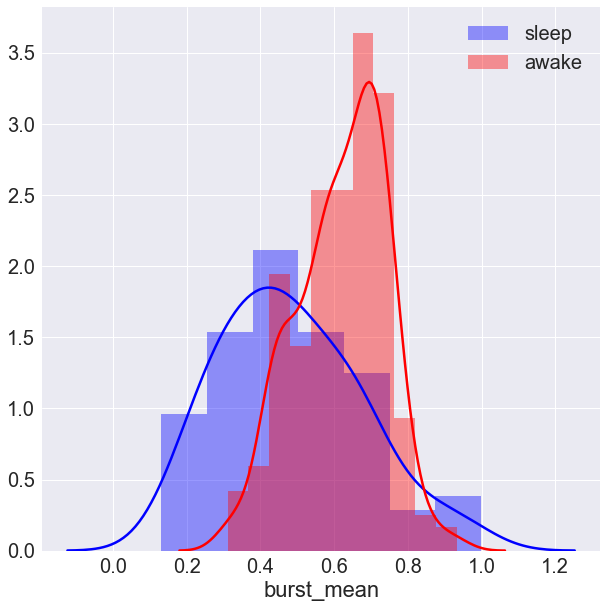

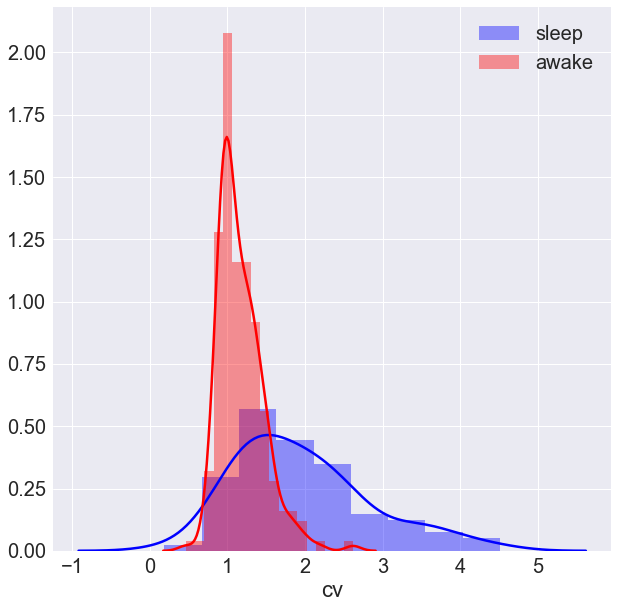

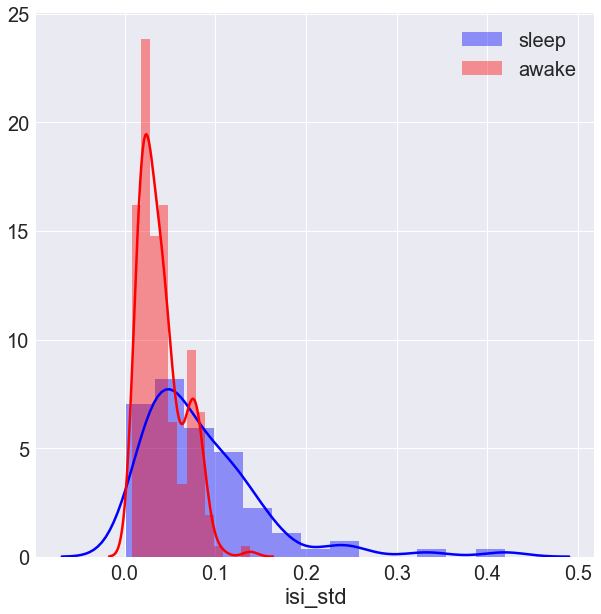

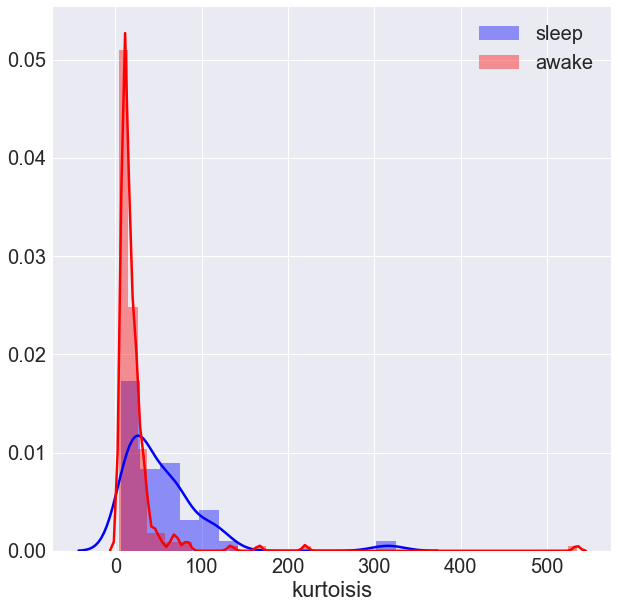

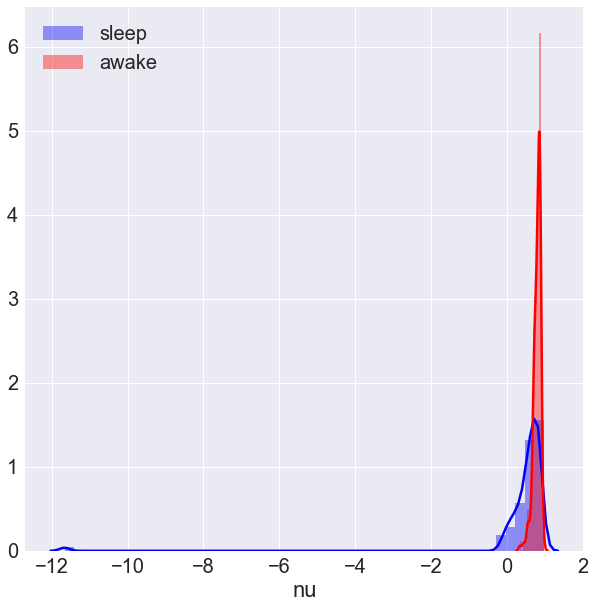

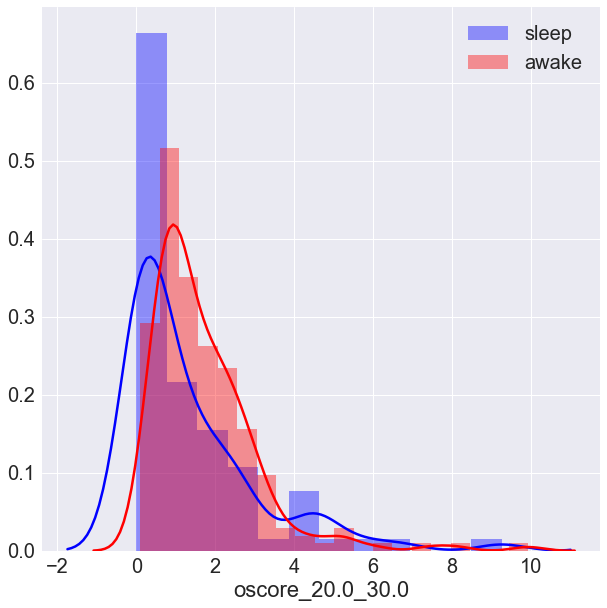

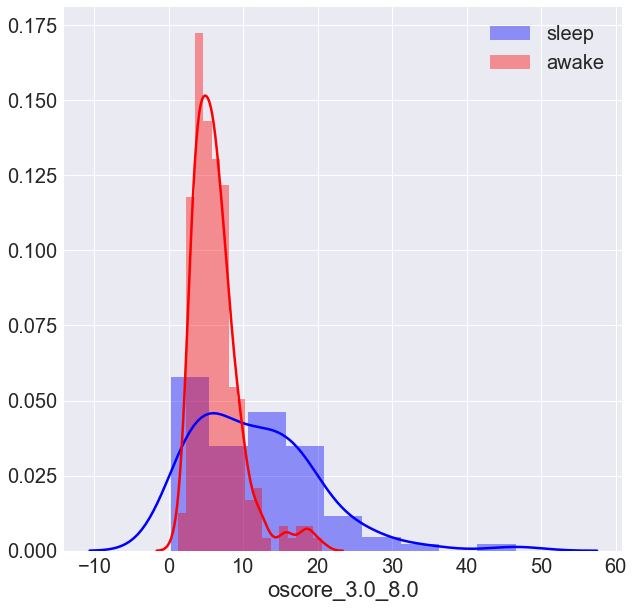

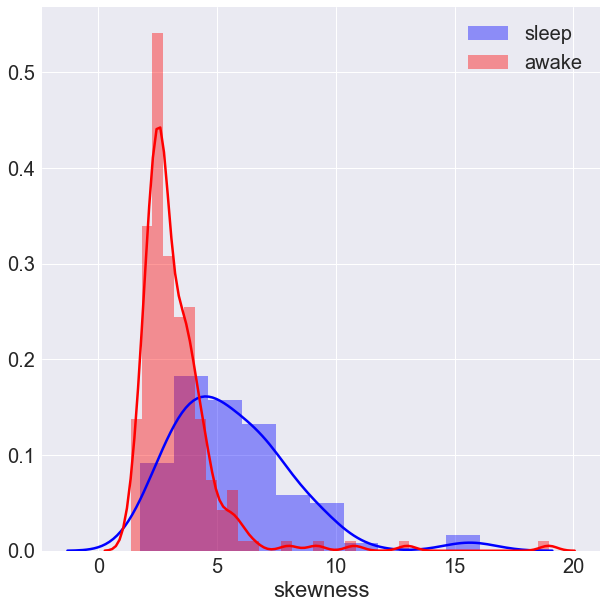

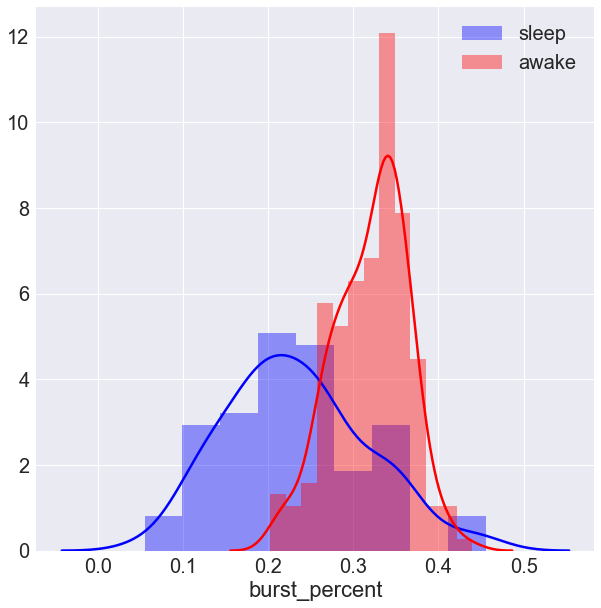

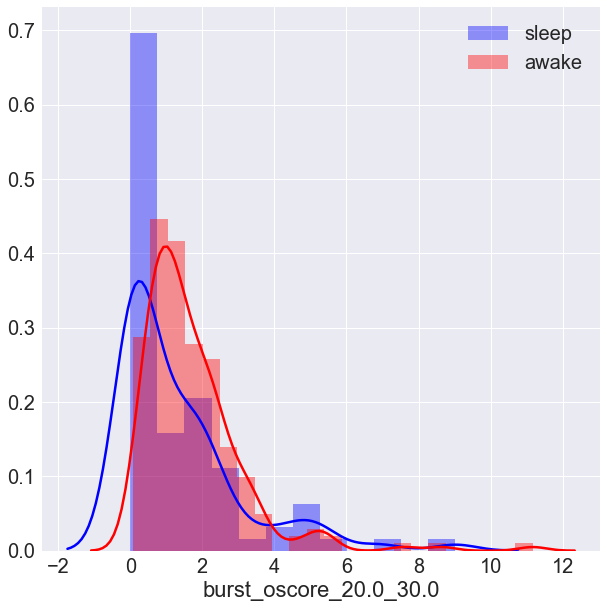

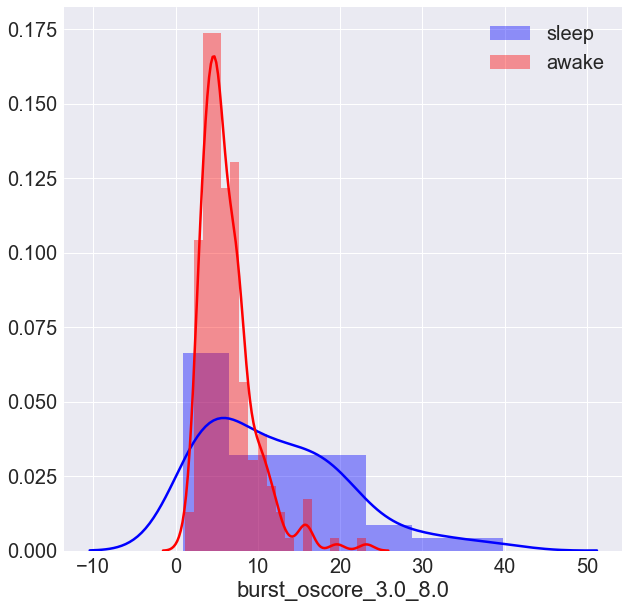

In [246]:
count = 0
for c in data_cols:
    sleep_data = data_sleep[c]
    awake_data = data_awake[c]
    
#     stat, pval = sp.stats.ttest_ind_from_stats(np.mean(sleep_data), np.var(sleep_data), len(sleep_data),
#                                                np.mean(awake_data), np.var(awake_data), len(awake_data))
    stat, pval = sp.stats.ks_2samp(sleep_data, awake_data)
    if pval < 1e-5:
        plt.figure(figsize=(10,10))
        sns.distplot(sleep_data, color='blue', label='sleep')
        sns.distplot(awake_data, color='red', label='awake')
#         plt.title(c)
        plt.legend()
#         count += 1
# print(count)

In [208]:
def fix_params(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    return params

def score(X, y, patients, model_type, pbar, cv_type, metric, params):
    params = fix_params(params)
    
    if cv_type == 'patient':
        accuracy, auc = patient_cv(X, y, patients, model_type, params, plot=False)
    elif cv_type == 'simple':
        accuracy, auc = simple_cv(X, y, patients, model_type, params, plot=False)
    else:
        raise RuntimeError('Uknown cv type!')
    
    if metric == 'auc':
        loss = -auc
    elif metric == 'accuracy':
        loss = -accuracy
    else:
        raise RuntimeError('Uknown metric for scoring!')
        
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}

def optimize(X, y, patients, trials, cv_type='simple', metric='accuracy', max_evals=250):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             }
    
    pbar = tqdm_notebook(total=max_evals)
    best_params = fmin(lambda params: score(X, y, patients, model_type, pbar, cv_type, metric, params), 
                       space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    return fix_params(best_params)

(0.83959044368600677, 0.82222601959444064)

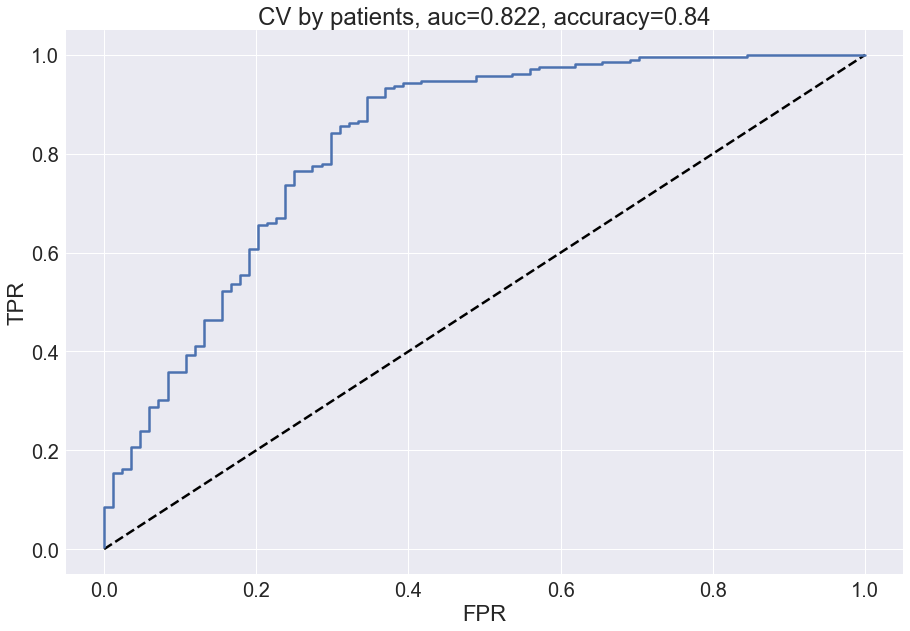

In [197]:
trials = Trials()
best_params = optimize(X, y, patients, trials, 'patient')

patient_cv(X, y, patients, best_params)

(0.88064228367528996, 0.88391433128275232)

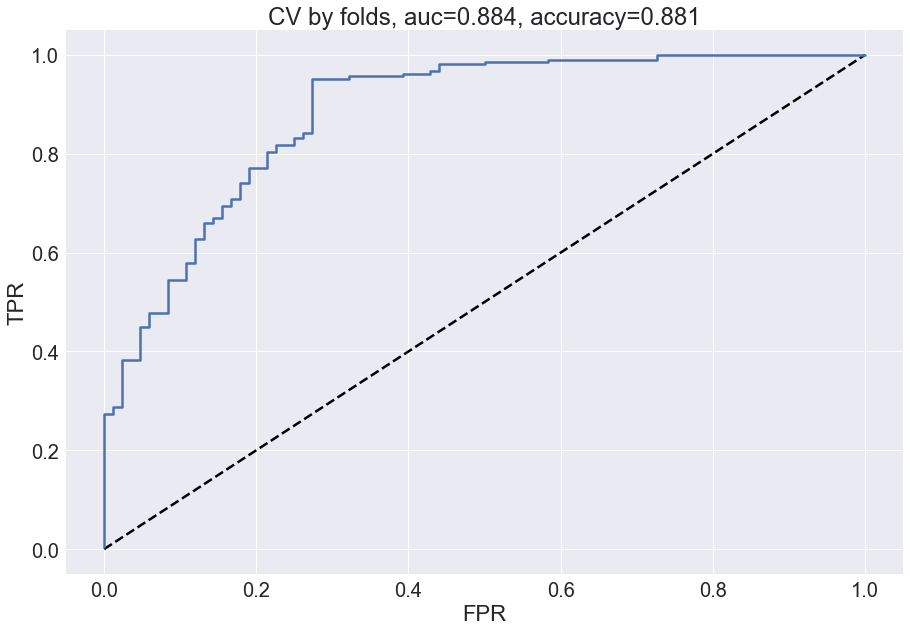

In [193]:
trials = Trials()
best_params = optimize(X, y, patients, trials, 'simple')

simple_cv(X, y, patients, best_params)

(0.83959044368600677, 0.83190931875142404)

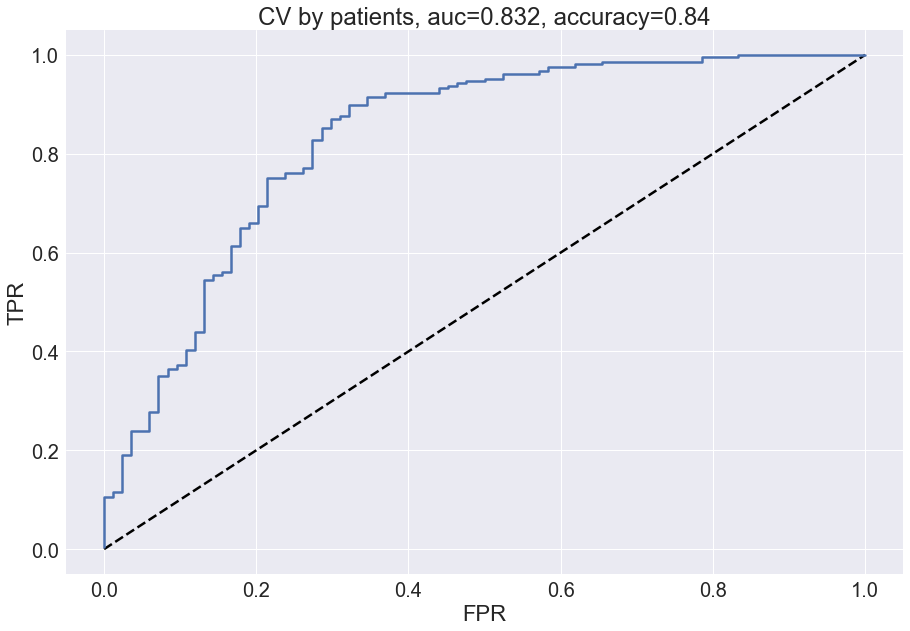

In [196]:
trials = Trials()
best_params = optimize(X_spiketrain, y, patients, trials, 'patient')

patient_cv(X_spiketrain, y, patients, best_params)

(0.8122866894197952, 0.79801777170198229)

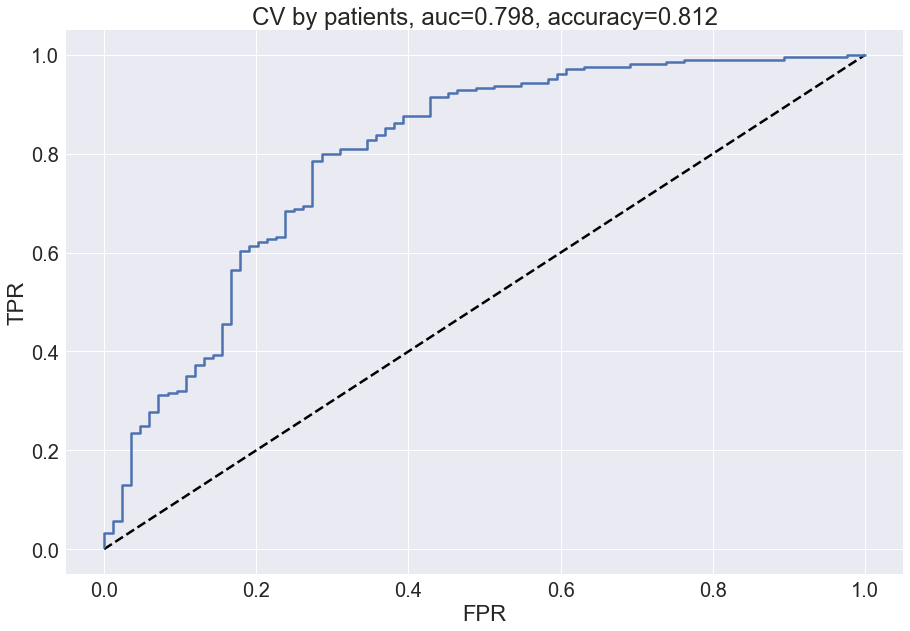

In [195]:
trials = Trials()
best_params = optimize(X_burst, y, patients, trials, 'patient')

patient_cv(X_burst, y, patients, best_params)

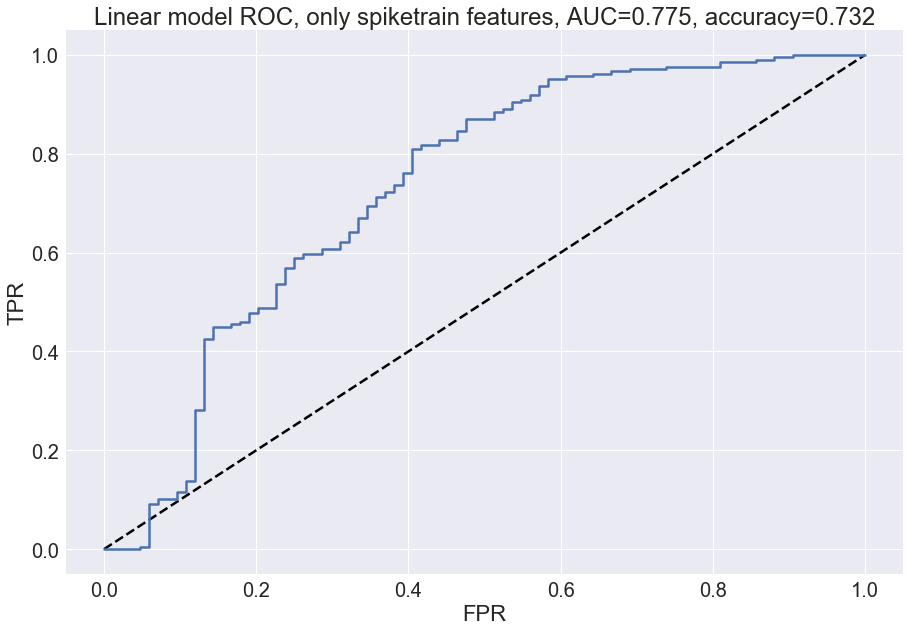

In [245]:
acc, auc_score = patient_cv(X_spiketrain, y, patients, 'linear', best_params)
plt.title('Linear model ROC, only spiketrain features, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

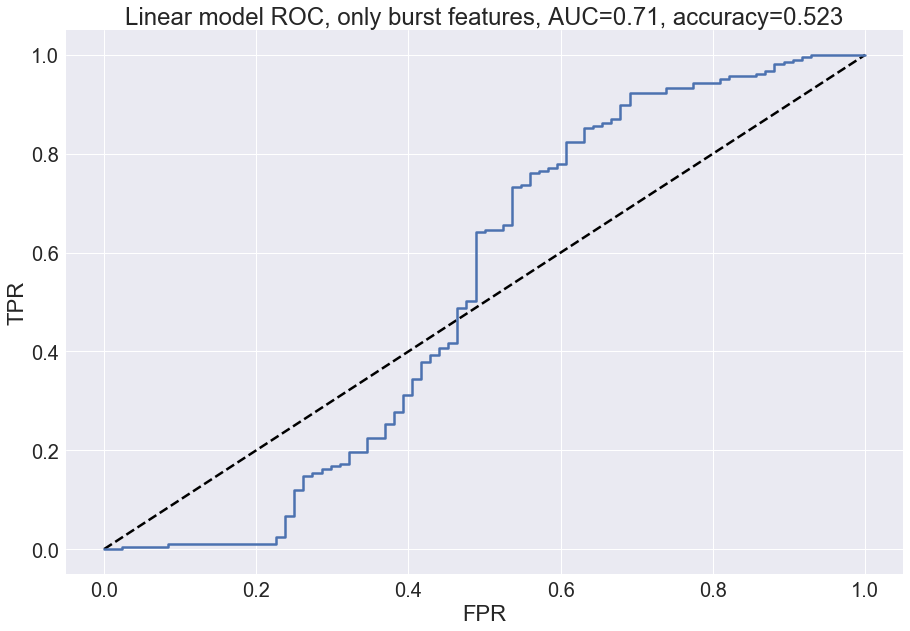

In [244]:
acc, auc_score = patient_cv(X_burst, y, patients, 'linear', best_params)
plt.title('Linear model ROC, only burst features, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

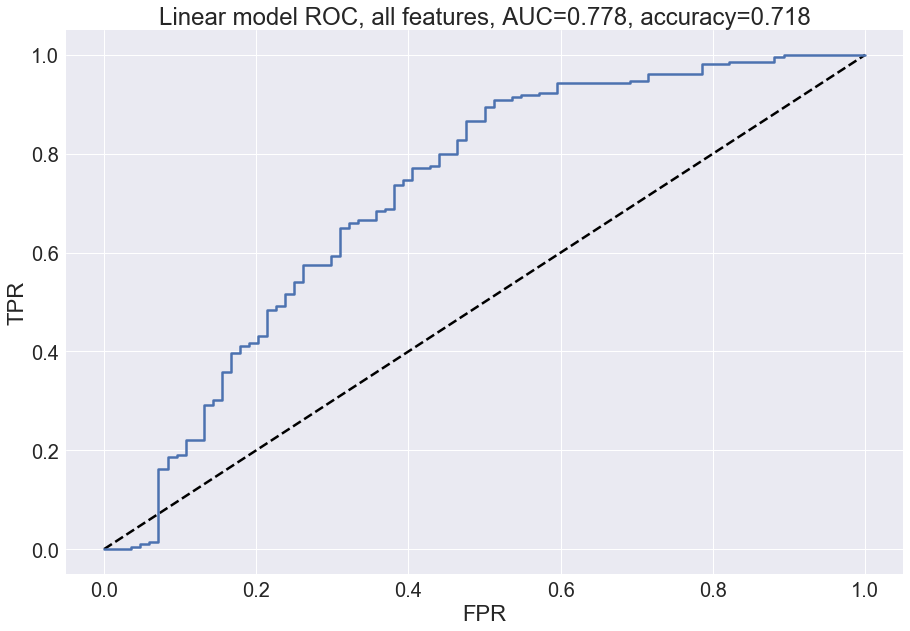

In [243]:
acc, auc_score = patient_cv(X, y, patients, 'linear', best_params)
plt.title('Linear model ROC, all features, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))